In [239]:
#import libraries to manipulate and visualize data 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import date
from pandas_datareader import wb
from pandas_datareader import data as web
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
import sys

In [240]:
#Choose period
start = datetime(2010, 1, 1)
end = date.today()

#Choose series
serie   = 'MSFT'
serie_2 = 'AMZN'
serie_3 = 'GOOGL'
serie_4 = '^GSPC'
serie_5 = '^VIX'

#import data 
tickers = [serie,serie_2,serie_3,serie_4,serie_5]
dataset = web.DataReader(tickers, 'yahoo',start,end)['Adj Close'].dropna()

In [241]:
#Type of obsevation Function
def choose_period(time_period,data):
    time_period = time_period.lower()
    if time_period == 'daily':
        period = 1
    elif time_period == 'weekly':
        period = 5
    elif time_period == 'monthly':
        period = 20
    else:
        print('introduce time period: Daily, Weekly or Monthly')
    data = data.dropna().iloc[::period,:]
    return data


In [242]:
#Choose type of observation: daily,weekly or monthly
time_period = 'daily'

#Create the dataset and calculate logaritmic returns
dataset = choose_period(time_period,dataset)
r_dataset = pd.DataFrame(np.log(dataset).diff(1))

#introduce delayed series in 3, 6 and 12 periods 
lag_series = pd.concat([np.log(dataset[serie]).diff(i) for i in [3, 6,12]], axis=1)
lag_series.index = r_dataset.index
r_dataset = pd.concat([r_dataset,lag_series],axis = 1).dropna()
r_dataset.columns = [serie,serie_2,serie_3,serie_4,serie_5,'lag_3','lag_6','lag_12']

#output: forecast
r_dataset['y'] = (r_dataset.loc[:,serie].shift(-1))
r_dataset = r_dataset.dropna()

In [243]:
#Split data
x = r_dataset.iloc[:,:-1]
y = r_dataset["y"]
size_test_data = 0.2
size_train_data = int(len(r_dataset) * (1-size_test_data))
x_train, x_test = x[0:size_train_data], x[size_train_data:len(x)]
y_train, y_test = y[0:size_train_data], y[size_train_data:len(y)]

count    2850.000000
mean        0.000819
std         0.015991
min        -0.159453
25%        -0.006875
50%         0.000696
75%         0.008732
max         0.132929
Name: MSFT, dtype: float64
ADF Statistic: -19.332033
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


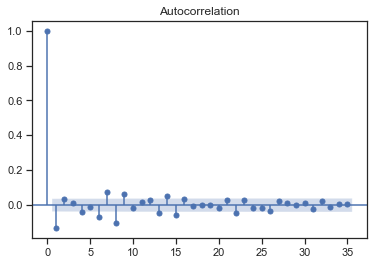

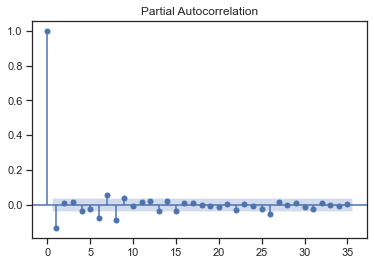

In [244]:
print(r_dataset[serie].describe())
plot_acf(r_dataset[serie])
plot_pacf(r_dataset[serie])
result=adfuller(r_dataset[serie].values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
plt.show()

In [245]:
def evaluate_arima(p,d,q):
    arima = ARIMA(endog=y_train,order = (p,d,q))
    model_fit = arima.fit()
    aic = model_fit.aic
    return aic
 
# evaluate combinations of p, d and q values for an ARIMA model
aic_results = []

models = []
p_values = [0, 1, 2]
d_values = list(range(0, 3))
q_values = list(range(0, 3))

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                aic = evaluate_arima(p,d,q)
                aic_results.append(aic)
                model = 'Arima ('+str(p)+','+str(d)+','+str(q)+')'
                models.append(model)
            except:
                continue


                

                
arima_results = pd.DataFrame(models)
arima_results.columns = ['model']
arima_results['aic'] = aic_results
arima_results

                
i_best_aic = aic_results.index(min(aic_results))

print('Best AIC: ' + arima_results['model'][i_best_aic])
best_aic_order = (int(arima_results['model'][i_best_aic][7]),int(arima_results['model'][i_best_aic][9]),int(arima_results['model'][i_best_aic][11]))


Best AIC: Arima (1,0,1)


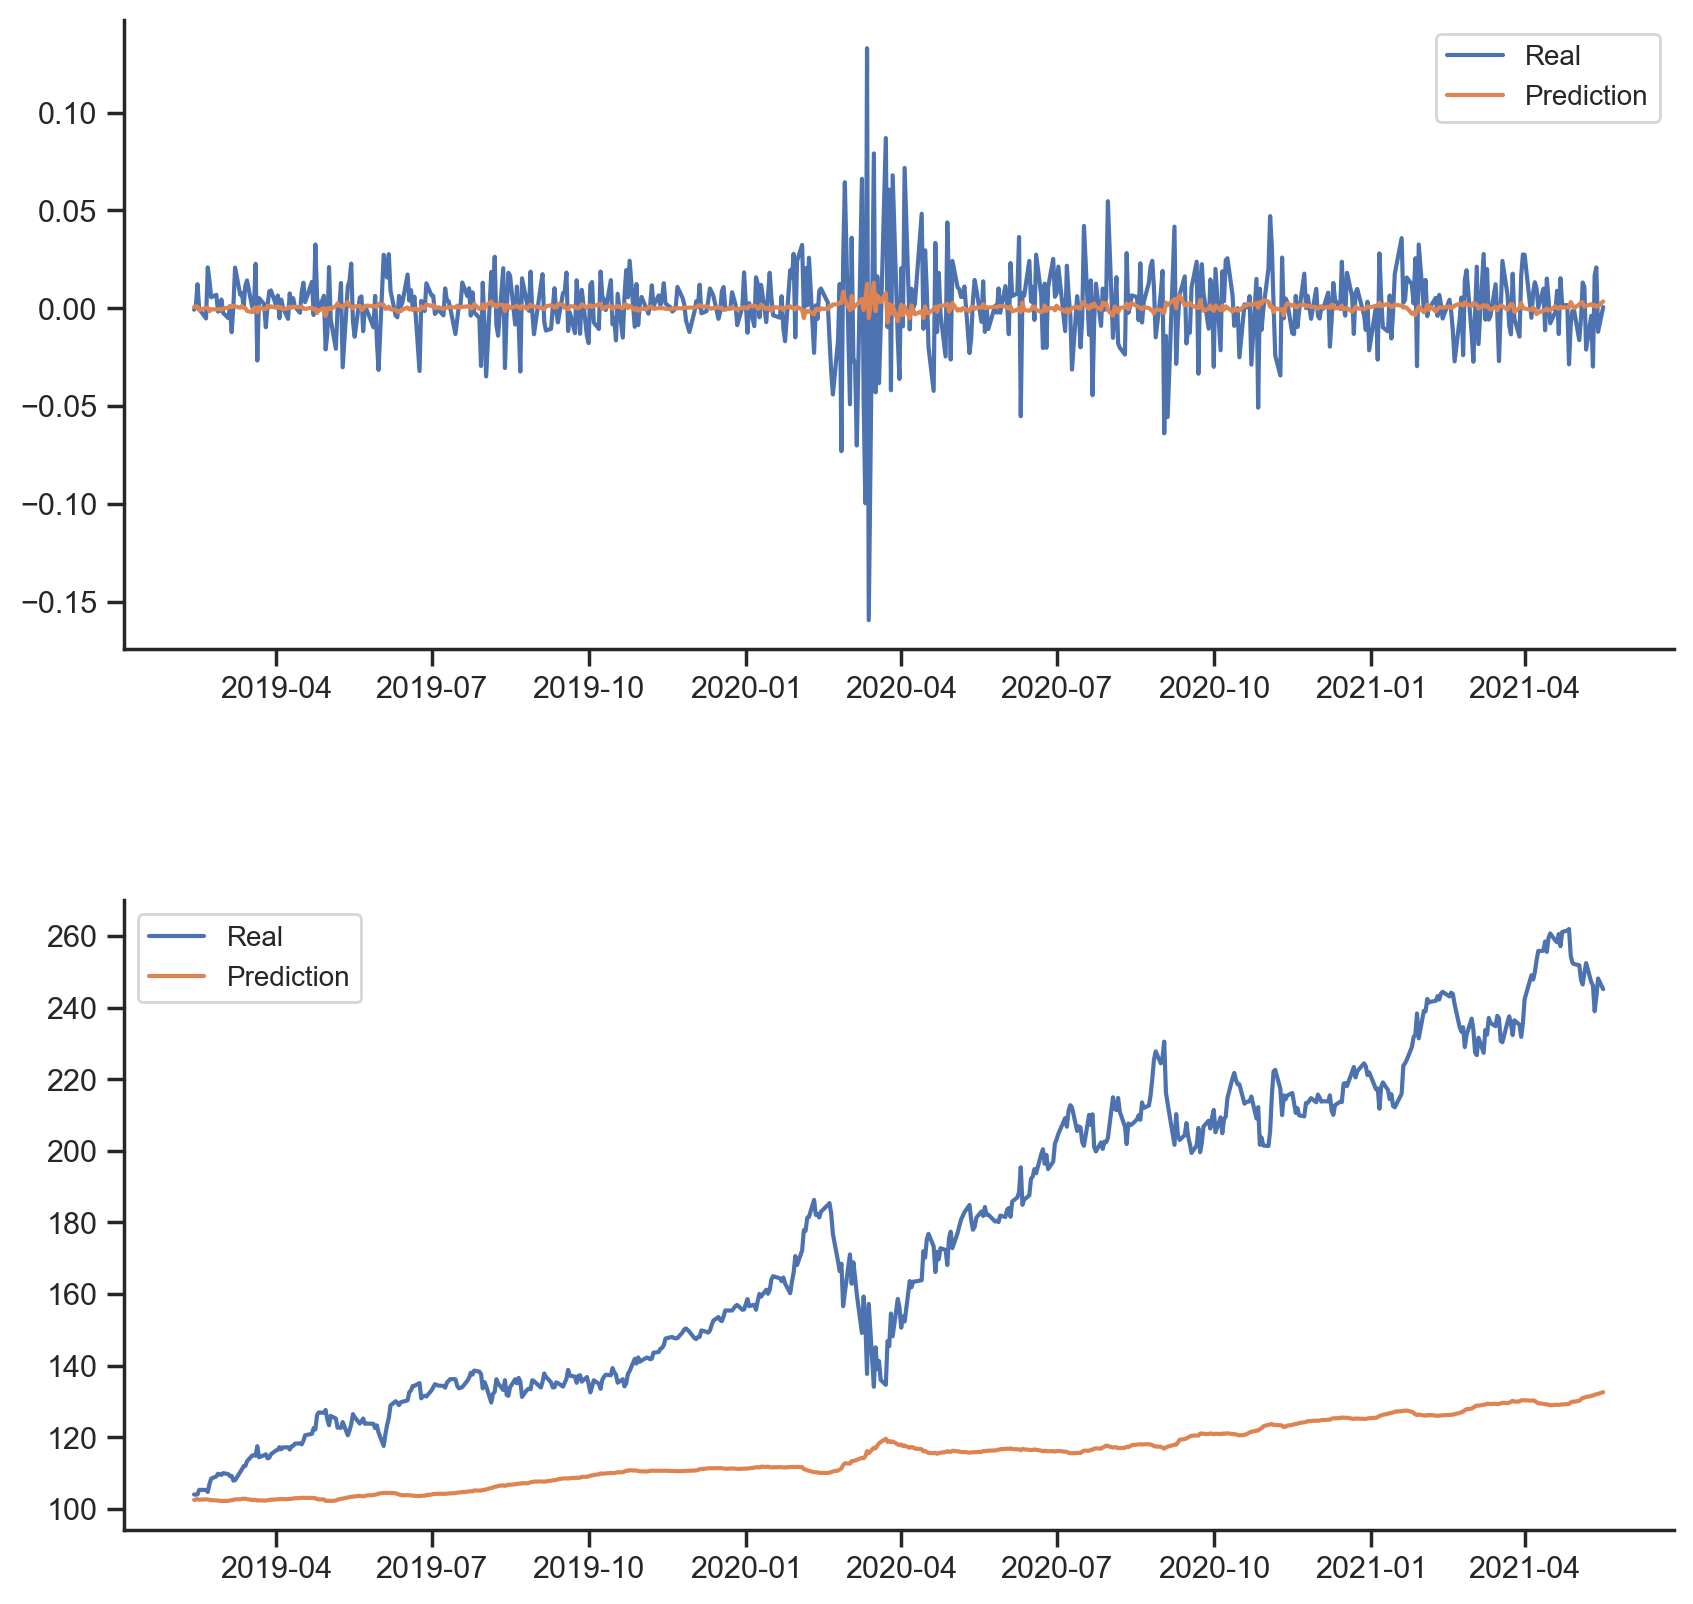

In [246]:
arima = ARIMA(endog=y_train ,order= best_aic_order ,exog = x_train)
arima_fit = arima.fit()
r_predict_arima = arima_fit.predict(start = len(y_train) ,end = len(y)-1,exog = x_test)
r_predict_arima.index = y_test.index

p_serie = dataset[serie]
p_serie_train = p_serie.loc[y_train.index]
p_serie_test = p_serie.loc[y_test.index]
p_0 = p_serie_train[-1]
p_predict_arima =  p_0*np.exp(r_predict_arima).cumprod()



#Color palette
palette = sns.color_palette('pastel')
#sns.palplot(palette)
sns.set_palette(palette)
sns.set_theme(style="ticks")

#Figure size
plt.figure(figsize=(10, 10), dpi = 200)

#Plot returns prediction
plt.subplot(2,1,1)
#plt.title( 'Returns: '+ results.model[i_best_model] + ' predict',fontsize = 15)
sns.despine()
sns.lineplot(y_test.index,y_test)
sns.lineplot(r_predict_arima.index,r_predict_arima)
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')

#Plot price prediction
plt.subplot(2,1,2)
#plt.title( 'Prices: '+ results.model[i_best_model] + ' predict vs real ' + serie,fontsize = 15)
sns.despine()
sns.lineplot(p_serie_test.index,p_serie_test)
sns.lineplot(p_serie_test.index,p_predict_arima)
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')


plt.subplots_adjust(hspace=0.40)
 
plt.show()
plt.close()



In [253]:
from arch import arch_model

def evaluate_garch(p,d,q):
    garch_model = arch_model(y_train,vol='Garch', p=p, o=o, q=q, dist='Normal')
    res = garch_model.fit(update_freq=5)
    aic = res.aic
    return aic
 
# evaluate combinations of p, d and q values for an ARIMA model
aic_results = []
mse_results = []
models = []
p_values = [0, 1, 2]
o_values = list(range(0, 3))
q_values = list(range(0, 3))

for p in p_values:
    for o in o_values:
        for q in q_values:
            try:
                aic = evaluate_garch(p,d,q)
                aic_results.append(aic)
                model = 'garch ('+str(p)+','+str(o)+','+str(q)+')'
                models.append(model)
            except:
                continue


Optimization terminated successfully    (Exit mode 0)
            Current function value: -6252.330568458119
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      5,   Func. Count:     57,   Neg. LLF: 6.391106480916459e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6482.254709080953
            Iterations: 12
            Function evaluations: 95
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6478.064676324075
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6307.047973118189
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
Iteration:      5,   Func. Count:     62,   Neg. LLF: 231291941764981.72
Iteration:     10,

In [254]:
garch_results = pd.DataFrame(models)

garch_results.columns = ['model']
garch_results['aic'] = aic_results
garch_results
            
i_best_aic = aic_results.index(min(garch_results['aic']))

print('Best AIC: ' + garch_results['model'][i_best_aic])

p = +int(garch_results['model'][i_best_aic][7])
o = +int(garch_results['model'][i_best_aic][9])
q = +int(garch_results['model'][i_best_aic][11])


Best AIC: garch (2,2,2)


Iteration:      1,   Func. Count:      9,   Neg. LLF: 26460838.349855404
Iteration:      2,   Func. Count:     22,   Neg. LLF: -917.0411387226119
Optimization terminated successfully    (Exit mode 0)
            Current function value: -917.0411392089427
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


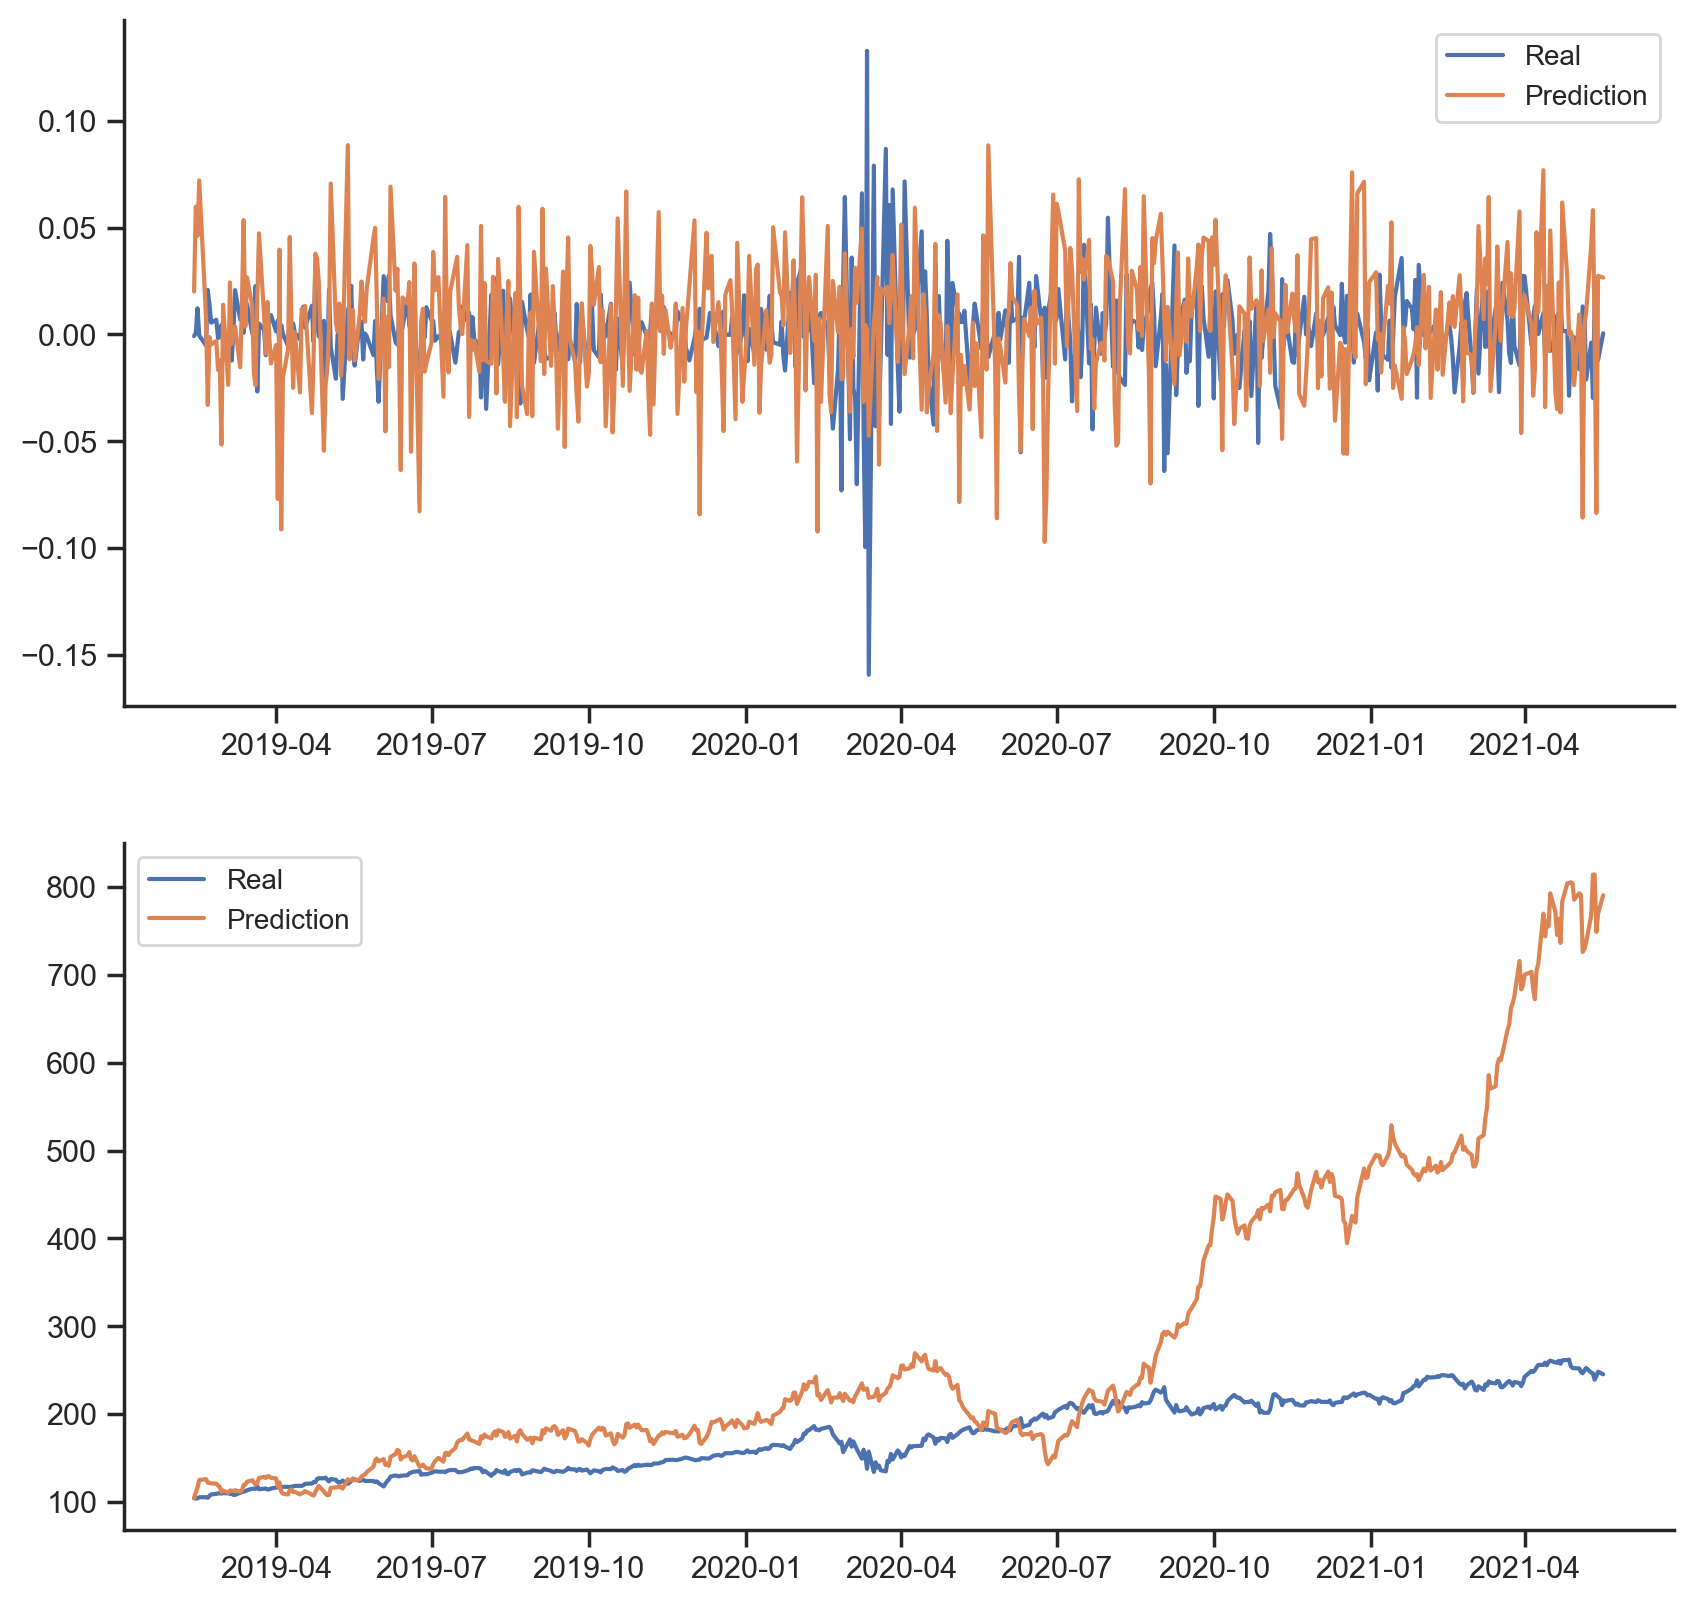

In [257]:
garch = arch_model(y_train,vol='Garch', p= p, o = o, q = q, dist='Normal')
garch_fit = best_garch.fit()
r_garch_predict = best_garch_fit.forecast(horizon=len(y_test))

r_garch_predict = r_garch_predict.mean.iloc[-3:]  + np.sqrt(r_garch_predict.variance.iloc[-3:]) * np.random.normal(0,1,len(y_test)) 


r_garch_predict = r_garch_predict.iloc[2,:]
r_garch_predict.index = y_test.index 

p_0 = p_serie_train[-1]
p_garch_predict =  p_0*np.exp(r_garch_predict).cumprod()

#Figure size
plt.figure(figsize=(10, 10), dpi = 200)

#Plot returns prediction
plt.subplot(2,1,1)
#plt.title( 'Returns: '+ results.model[i_best_model] + ' predict',fontsize = 15)
sns.despine()
sns.lineplot(y_test.index,y_test)
sns.lineplot(r_garch_predict.index,r_garch_predict)
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')

#Plot price prediction
plt.subplot(2,1,2)
#plt.title( 'Prices: '+ results.model[i_best_model] + ' predict vs real ' + serie,fontsize = 15)
sns.despine()
sns.lineplot(p_serie_test.index,p_serie_test)
sns.lineplot(p_serie_test.index,p_garch_predict)
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')


#plt.subplots_adjust(hspace=0.40)
 
plt.show()
plt.close()

In [258]:
#Split data for LSTM model
x_train_LSTM, x_test_LSTM = np.array(x_train), np.array(x_test)
y_train_LSTM, y_test_LSTM = np.array(y_train), np.array(y_test)
x_train_LSTM= x_train_LSTM.reshape((x_train_LSTM.shape[0], 1, x_train_LSTM.shape[1]))
x_test_LSTM= x_test_LSTM.reshape((x_test_LSTM.shape[0], 1, x_test_LSTM.shape[1]))
print(x_train_LSTM.shape, y_train_LSTM.shape, x_test_LSTM.shape, y_test_LSTM.shape)

(2280, 1, 8) (2280,) (570, 1, 8) (570,)


In [259]:
# design network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train_LSTM.shape[1], x_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(x_train_LSTM, y_train_LSTM, validation_data=(x_test_LSTM, y_test_LSTM),epochs=50, batch_size=72, verbose=0, shuffle=False)

# evaluate an LSTM model for a given order (p,d,q)
def evaluate_LSTM_model(neurons=12, learn_rate = 0.01, momentum=0):
    #predicted = list()     
    LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
    LSTMModel_fit = LSTMModel.fit(x_train_LSTM, y_train_LSTM,epochs=50, batch_size=72, verbose=0, shuffle=False)
    predicted = LSTMModel.predict(x_test_LSTM)
    error = mean_squared_error(predicted, y_test)
    return error

def evaluate_combinations_LSTM(neurons, learn_rate, momentum): 
    results = []
    models = []
    for n in neurons:
        for l in learn_rate:
            for m in momentum:
                try:
                    mse = evaluate_LSTM_model(n,l,m)                    
                    results.append(mse)
                    model = [n,l,m]
                    models.append(model)
                except:
                    continue
    return results, models

In [260]:
# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
warnings.filterwarnings("ignore")
results, models =  evaluate_combinations_LSTM(neurons,learn_rate,momentum)

i_best_MSE = results.index(min(results))
print('Best model:\n Neurons: ' + str(LSTM_results['neurons'][i_best_MSE]) + '; learn rate: ' +str(LSTM_results['learn_rate'][i_best_MSE]) +'; momentum: '+ str(LSTM_results['momentum'][i_best_MSE]))

neurons = LSTM_results['neurons'][i_best_MSE]
learn_rate = LSTM_results['learn_rate'][i_best_MSE]
momentum =  LSTM_results['momentum'][i_best_MSE]

Best model:
 Neurons: 1; learn rate: 0.001; momentum: 0.9


In [261]:
def create_LSTMmodel(neurons , learn_rate, momentum):
    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train_LSTM.shape[1], x_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model


Text(0.5, 0, '')

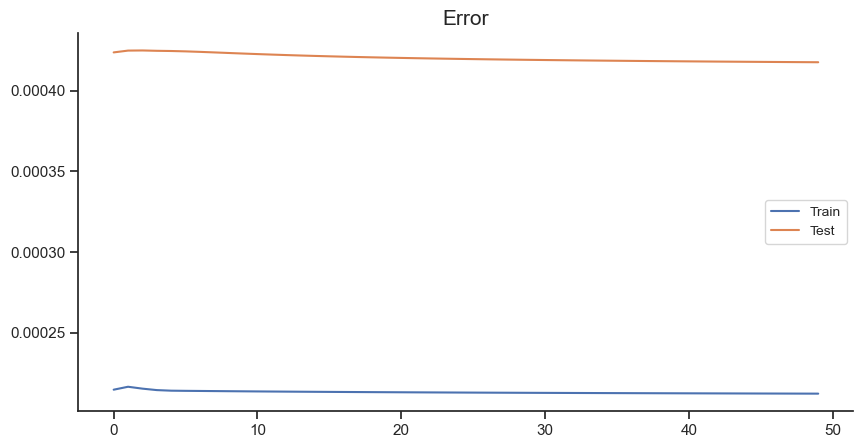

In [262]:
LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
LSTMModel_fit = LSTMModel.fit(x_train_LSTM, y_train_LSTM, validation_data=(x_test_LSTM, y_test_LSTM),epochs=50, batch_size=72, verbose=0, shuffle=False)
epochs = list(range(50))

plt.figure(figsize=(10, 5), dpi = 100)
plt.title( 'Error',fontsize = 15)
sns.despine()
sns.lineplot(epochs,LSTMModel_fit.history['loss'])
sns.lineplot(epochs,LSTMModel_fit.history['val_loss'])
plt.legend(['Train','Test'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')



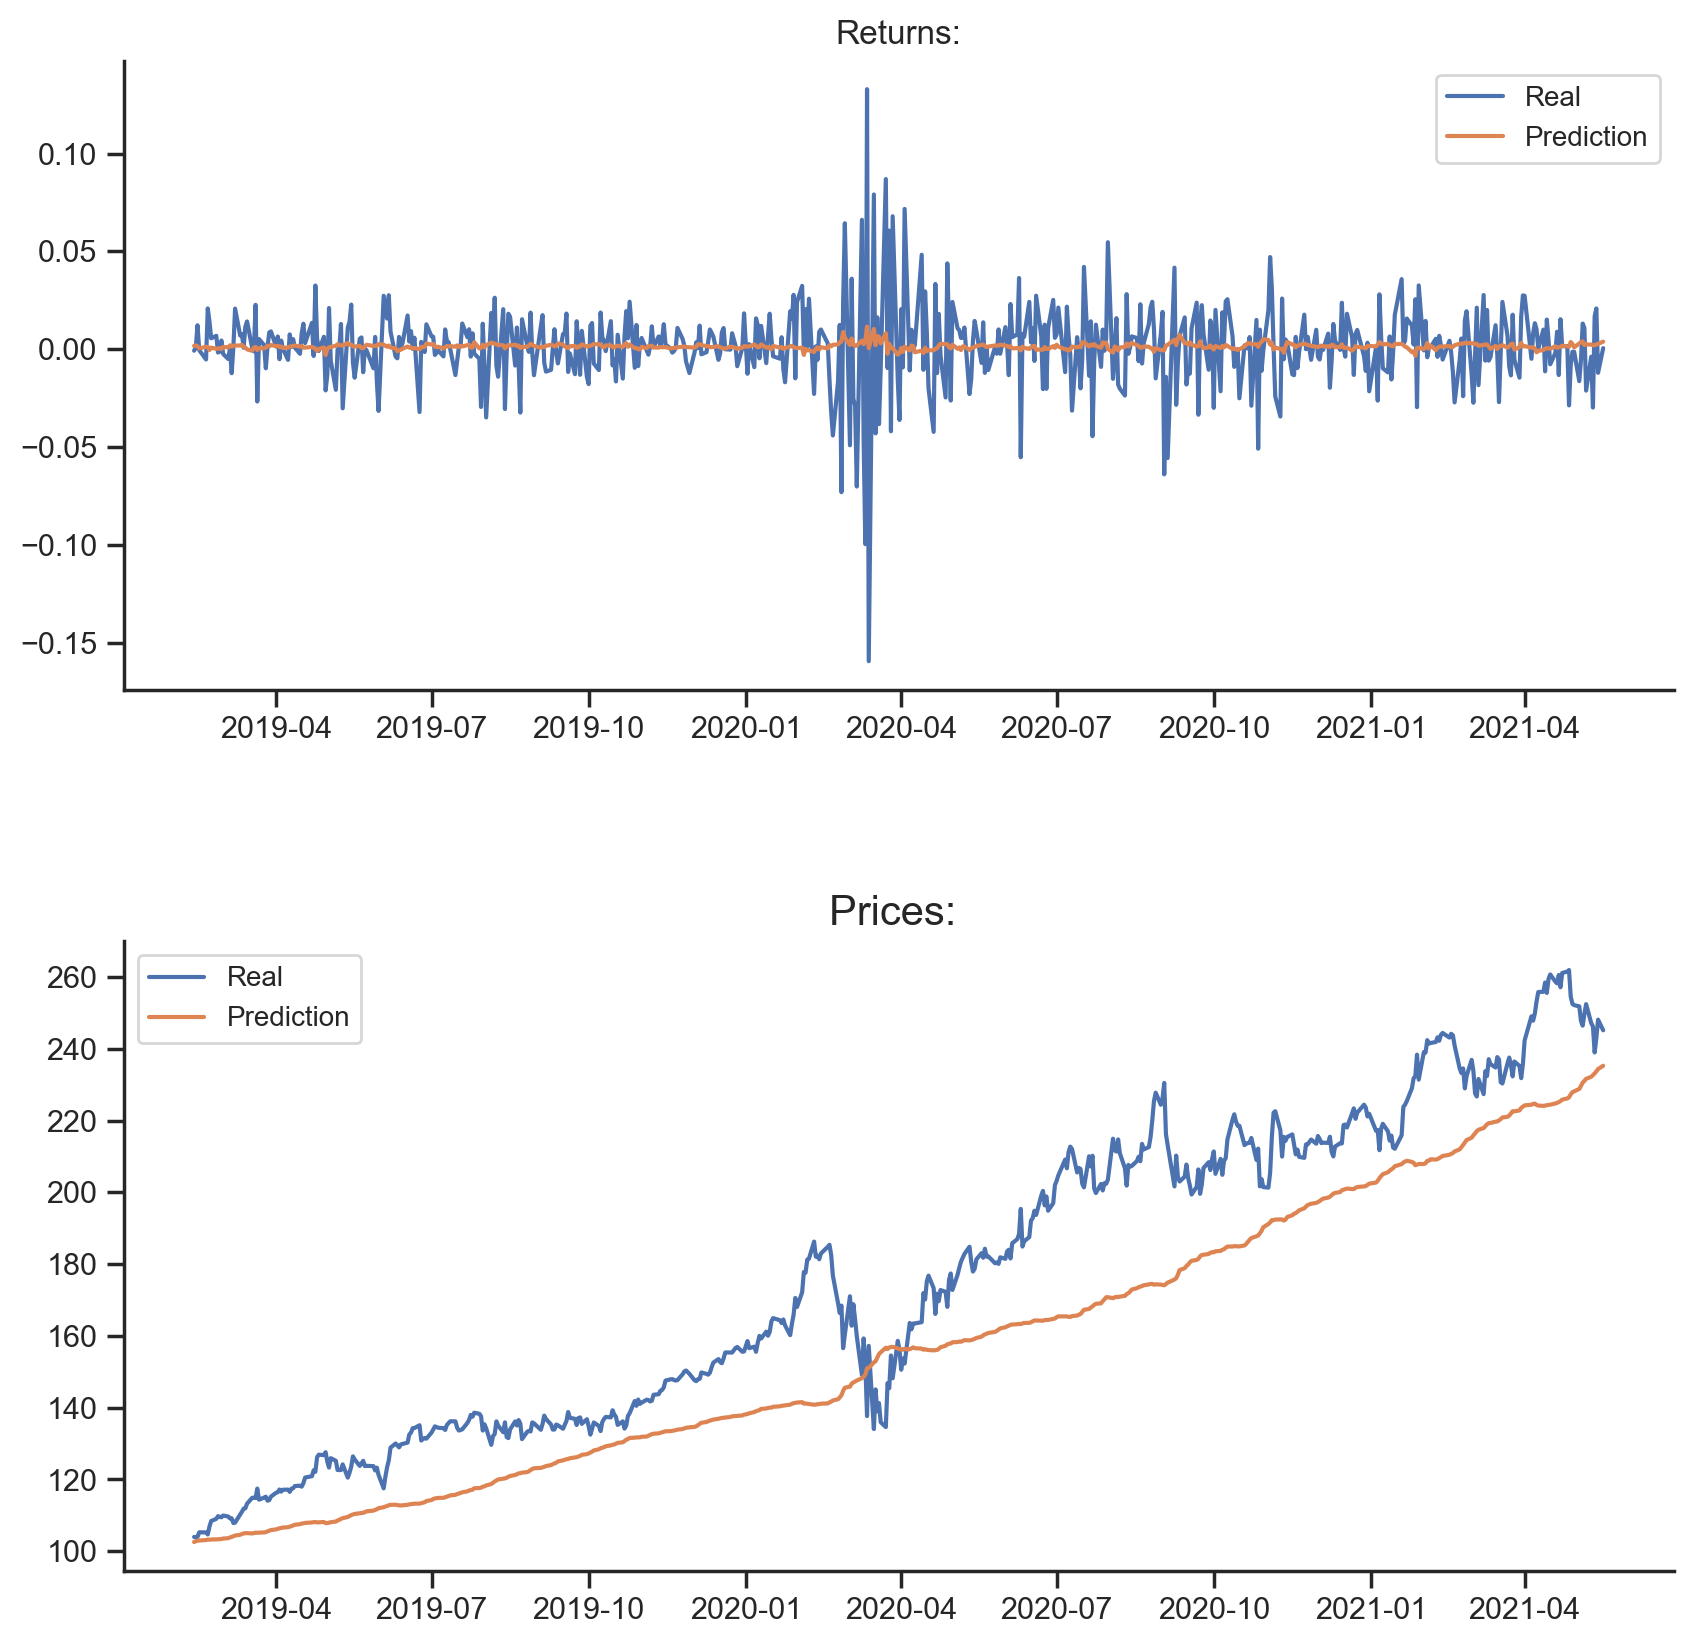

In [263]:

r_LSTM_predict = pd.DataFrame(LSTMModel.predict(x_test_LSTM))

r_LSTM_predict.columns = ['r']

r_LSTM_predict.index = y_test.index 
r_LSTM_predict

p_0 = p_serie_train[-1]


p_LSTM_predict =  p_0*np.exp(r_LSTM_predict['r']).cumprod()

#Figure size
plt.figure(figsize=(10, 10), dpi = 200)

#Plot returns prediction
plt.subplot(2,1,1)
plt.title( 'Returns:')
sns.despine()
sns.lineplot(y_test.index,y_test)
sns.lineplot(r_LSTM_predict.index,r_LSTM_predict['r'])
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')

#Plot price prediction
plt.subplot(2,1,2)
plt.title( 'Prices: ',fontsize = 15)
sns.despine()
sns.lineplot(p_serie_test.index,p_serie_test)
sns.lineplot(p_LSTM_predict.index,p_LSTM_predict)
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')


plt.subplots_adjust(hspace=0.40)
 
plt.show()
plt.close()